In [1]:
using Pkg; Pkg.activate("../../../FermiCG/")
using FermiCG
using PyCall
using Plots
using LinearAlgebra
using Printf
using JLD2

  Activating project at `~/code/FermiCG`


In [2]:
#molecule = "
#He 0.00000000 0.00000000 0.00000000
#He 1.41421356 0.00000000 0.00000000
#He 0.00000000 1.41421356 0.00000000
#He 1.41421356 1.41421356 0.00000000
#He 0.70710678 0.70710678 1.00000000
#He 0.70710678 0.70710678 -1.00000000
#"
#molecule = "
#He 0.00000000 0.00000000 0.00000000
#He 2.12132035 0.00000000 0.00000000
#He 0.00000000 2.12132035 0.00000000
#He 2.12132034 2.12132034 0.00000000
#He 1.06066017 1.06066017 1.50000000
#He 1.06066017 1.06066017 -1.50000000
#"
molecule = "
He       0.0000000000000000       0.0000000000000000       0.0000000000000000
He       3.8890872900000004       0.0000000000000000       0.0000000000000000
He       0.0000000000000000       3.8890872900000004       0.0000000000000000
He       3.8890872900000004       3.8890872900000004       0.0000000000000000
He       1.9445436450000002       1.9445436450000002       2.7500000000000000
He       1.9445436450000002       1.9445436450000002      -2.7500000000000000
"
atoms = []
for (li,line) in enumerate(split(rstrip(lstrip(molecule)), "\n"))
    l = split(line)
    push!(atoms, Atom(li, l[1], parse.(Float64,l[2:4])))
end

basis = "aug-cc-pvdz"

# Create FermiCG.Molecule type
mol     = Molecule(0, 1, atoms,basis);

pyscf = pyimport("pyscf")

n_steps = 35
step_size = .05

pymol_init = pyscf.gto.Mole(atom=molecule,
                            symmetry = false, spin =0,charge=0,
                            basis = basis)
pymol_init.build()

PyObject <pyscf.gto.mole.Mole object at 0x7fb498419750>

In [3]:
io = open("traj.xyz", "w");
energies_ground = []
energies_t1 = []
energies_t2 = []
energies_t3 = []
energies_t4 = []
energies_t5 = []
energies_t6 = []

energies_s1 = []
energies_s2 = []
energies_s3 = []
energies_s4 = []
energies_s5 = []
energies_s6 = []

energies_t7 = []
energies_t8 = []
energies_t9 = []
energies_t10 = []
energies_t11 = []
energies_t12 = []
pt2_energies = []

lo = pyimport("pyscf.lo.orth")
tools = pyimport("pyscf.tools")
fcidump = pyimport("pyscf.tools.fcidump");

In [5]:
pymol = deepcopy(pymol_init)
#scale = 1+1*step_size
#scale = 1
#move to smaller geometry
#xyz = @sprintf("%5i\n\n", length(mol.atoms))
#tmp = []

#for a in mol.atoms
#    push!(tmp, ["He", (a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)])
#    xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)
#end

#pymol.atom = tmp
#pymol.build()

#mf = pyscf.scf.RHF(pymol).run()
#@time s = mf.get_ovlp(pymol)
#@time s2 = pymol.intor_symmetric("int1e_ovlp")
#lo_ao = lo.orth_ao(mf, "lowdin", pre_orth_ao=nothing)
#lo_ao = lo.lowdin(s)
#tools.fcidump.from_mo(pymol, "fcidump.he06_oct", lo_ao)

#Can just read in pyscf dump file for integrals (once you have already run an scf calculation)
#ctx = fcidump.read("fcidump.he06_oct");
#h = ctx["H1"];
#g = ctx["H2"];
#ecore = ctx["ECORE"];
#g = pyscf.ao2mo.restore("1", g, size(h,2))

#This one below was not working. Error: setfield! immutable struct of type InCoreInts cannot be changed
#ints = InCoreInts(ecore,h,g);

#Define clusters and intial Fock space for inital CMF calc for 9 orbs each He
#clusters_in = [(1:9),(10:18), (19:27), (28:36), (37:45), (46:54)]

#Define clusters and intial Fock space for inital CMF calc for 5 orbs each He
#init_fspace = [(1,1),(1,1),(1,1),(1,1),(1,1),(1,1)]
#rdm1 = zeros(size(ints.h1))
#na=6
#nb=6

#Define clusters now using FermiCG code
#clusters = [Cluster(i,collect(clusters_in[i])) for i = 1:length(clusters_in)]
#display(clusters)
        
#do a CMF calculation to optimize cluster orbitals
#e_cmf, U, Da, Db = FermiCG.cmf_oo(ints, clusters, init_fspace, rdm1, rdm1, max_iter_oo=100, verbose=0, gconv=1e-6, method="bfgs", sequential=true);
#FermiCG.pyscf_write_molden(mol,lo_ao*U, filename="cmf.molden");

#U_old = U
#C_old = lo_ao*U
#lo_ao_old = lo_ao
#Da_old = Da
#Db_old = Db
#@save "start_var.jld2" U_old C_old lo_ao_old Da_old Db_old
#@load "start_var.jld2"

for R in 1:n_steps
    println("\n*********** Iteration: ", R, " *************")
    #pymol = deepcopy(pymol_init)
    scale = 1+R*step_size
    #scale = 1
    
    #move to smaller geometry
    xyz = @sprintf("%5i\n\n", length(mol.atoms))
    tmp = []
    #for a in mol.atoms
    #    push!(tmp, ["He", (a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)])
    #    xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)
    #end
    
    #move to larger geometry
    for a in mol.atoms
        push!(tmp, ["He", (a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)])
        xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)
    end
    
    pymol.atom = tmp
    pymol.build()
    println(xyz)
    write(io, xyz);

    mf = pyscf.scf.RHF(pymol).run()
    s = mf.get_ovlp(pymol)
    lo_ao = lo.lowdin(s)
    #Symmetric Orthogonalization
    #For reference C_old = lo_ao*U, lo_ao at geom1 and U is from cmf from geom1,
    # s is at geom2
  
    
    P = C_old'*s*C_old
    E = eigen(P)
    
    #P_half = E.vectors * Diagonal( 1 ./ sqrt.(E.values)) * E.vectors'
    
    #trying = val.^(-1/2)
    #values = Diagonal(val.^(-1/2))
    #values = Diagonal(trying)
    #P_half  = vec*values*vec'
    #C_new = C_old*P_half
    
    C_new = C_old * inv(sqrt(P))
    #C_new = C_old
   
    #C_new = lo_ao*U_old
    #println("size of Lowdin ortho AO's:", size(lo_ao))
    
    #val, vec = eigen(s)
    #values = Diagonal(val.^(-1/2))
    #S_half  = vec*values*vec'
    
    #write fci dump file from the modified mo coefficients
    tools.fcidump.from_mo(pymol, "fcidump.he06_oct", C_new)
    
    #Can just read in pyscf dump file for integrals (once you have already run an scf calculation)
    ctx = fcidump.read("fcidump.he06_oct");
    h = ctx["H1"];
    g = ctx["H2"];
    ecore = ctx["ECORE"];
    g = pyscf.ao2mo.restore("1", g, size(h,2))

    #This one below was not working. Error: setfield! immutable struct of type InCoreInts cannot be changed
    ints = InCoreInts(ecore,h,g);
    
    #Define clusters and intial Fock space for inital CMF calc for 9 orbs each He
    clusters_in = [(1:9),(10:18), (19:27), (28:36), (37:45), (46:54)]

    #Define clusters and intial Fock space for inital CMF calc for 5 orbs each He
    init_fspace = [(1,1),(1,1),(1,1),(1,1),(1,1),(1,1)]
    rdm1 = zeros(size(ints.h1))
    na=6
    nb=6

    #Define clusters now using FermiCG code
    clusters = [Cluster(i,collect(clusters_in[i])) for i = 1:length(clusters_in)]
    #display(clusters)
        
    #do a CMF calculation to optimize cluster orbitals
    #e_cmf, U, Da, Db = FermiCG.cmf_oo(ints, clusters, init_fspace, rdm1, rdm1, max_iter_oo=200, verbose=0, gconv=1e-6, method="bfgs", sequential=true);
    e_cmf, U, Da, Db = FermiCG.cmf_oo(ints, clusters, init_fspace, Da_old, Db_old, max_iter_oo=200, verbose=0, gconv=1e-6, method="bfgs", sequential=true);
    #FermiCG.pyscf_write_molden(mol,C_new*U, filename="cmf.molden");
    
    U_old = U
    C_old = C_new*U
    lo_ao_old = lo_ao
    Da_old = Da
    Db_old = Db
    C_cmf = C_new*U
    @save "cmf_"*string(R)*".jld2" e_cmf U Da Db C_cmf
    continue
    #rotate the integrals by the cmf calculation
    ints = FermiCG.orbital_rotation(ints, U);
    max_roots = 40

    #Build Cluster Basis (delta n is here)
    cluster_bases = FermiCG.compute_cluster_eigenbasis(ints, clusters, delta_elec=2, verbose=1, max_roots=max_roots, init_fspace=init_fspace, rdm1a=Da, rdm1b=Db);

    #@save "scan_after_cmf.jld2" ints Da Db e_cmf cluster_bases clusters init_fspace

    #Build Clustered Operator
    cluster_ham = FermiCG.extract_ClusteredTerms(ints, clusters);
    
    #Build Cluster Operators
    cluster_ops = FermiCG.compute_cluster_ops(cluster_bases, ints);
    FermiCG.add_cmf_operators!(cluster_ops, cluster_bases, ints, Da, Db);
    
    #Need to find reference state 
    ref_fock = FermiCG.FockConfig(init_fspace)
    nroots = 19
    #ci_vector = FermiCG.TPSCIstate(clusters, ref_fock, R=nroots)
    ci_vector = FermiCG.TPSCIstate(clusters, FermiCG.FockConfig(init_fspace), R=nroots);
    #ci_vector = FermiCG.ClusteredState(clusters, ref_fock, R=nroots);
    #Need to find the automated way to define these other excited configs away from ref state, example is to large
    #to do by hand
    #probably something to do with building p spaces and q spaces
    
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([2,1,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,2,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,2,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,2,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,2,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,1,2])] = zeros(Float64,nroots)
    
    ci_vector[ref_fock][ClusterConfig([3,1,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,3,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,3,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,3,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,3,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,1,3])] = zeros(Float64,nroots)
    
    ci_vector[ref_fock][ClusterConfig([4,1,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,4,1,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,4,1,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,4,1,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,4,1])] = zeros(Float64,nroots)
    ci_vector[ref_fock][ClusterConfig([1,1,1,1,1,4])] = zeros(Float64,nroots)

    FermiCG.eye!(ci_vector)
    #display(ci_vector)

    #for thresh_cipsi in thresh_list
    e0, v0 = FermiCG.tpsci_ci(ci_vector, cluster_ops, cluster_ham,
                              thresh_cipsi=1e-3, # Threshold for adding to P-space
                              #thresh_cipsi=thresh_cipsi, # Threshold for adding to P-space
                              thresh_foi=1e-2,    # Threshold for keeping terms when defining FOIS
                              thresh_asci=1e-1,     # Threshold of P-space configs to search from
                              max_iter=10);

    @time e2 = FermiCG.compute_pt2_energy(v0, cluster_ops, cluster_ham, thresh_foi=1e-8)
    #name = "eq_tpsci_results"*string(0.001)*".jld2"
    #@save name e0 e2 v0 ecore
    
    println()
    println("	*======TPSCI results======*")
    @printf("TCI Thresh: %8.6f  Dim:%8d\n",1e-2,size(v0)[1])
    println()
    @printf("TCI %5s %12s %12s\n", "Root", "E(0)", "E(2)") 
    for r in 1:nroots
        @printf("TCI %5s %12.8f %12.8f\n",r, e0[r] + ecore, e0[r] + e2[r] + ecore)
        display(v0,thresh=1e-4,root=r)
    end
    #end
    
    push!(energies_ground, e0[1]+ecore)
    push!(energies_t1, e0[2]+ecore)
    push!(energies_t2, e0[3]+ecore)
    push!(energies_t3, e0[4]+ecore)
    push!(energies_t4, e0[5]+ecore)
    push!(energies_t5, e0[6]+ecore)
    push!(energies_t6, e0[7]+ecore)
    
    push!(energies_s1, e0[8]+ecore)
    push!(energies_s2, e0[9]+ecore)
    push!(energies_s3, e0[10]+ecore)
    push!(energies_s4, e0[11]+ecore)
    push!(energies_s5, e0[12]+ecore)
    push!(energies_s6, e0[13]+ecore)

    push!(energies_t7, e0[14]+ecore)
    push!(energies_t8, e0[15]+ecore)
    push!(energies_t9, e0[16]+ecore)
    push!(energies_t10, e0[17]+ecore)
    push!(energies_t11, e0[18]+ecore)
    push!(energies_t12, e0[19]+ecore)

    push!(pt2_energies, e2)
end


*********** Iteration: 80 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He      19.4454364500000025       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000      19.4454364500000025       0.0000000000000000 
    He      19.4454364500000025      19.4454364500000025       0.0000000000000000 
    He       9.7227182250000013       9.7227182250000013      13.7500000000000000 
    He       9.7227182250000013       9.7227182250000013     -13.7500000000000000 



LoadError: here

In [154]:
@save "nb_scan_energies_triplet.jld2" energies_ground energies_t1 energies_t2 energies_t3 energies_t4 energies_t5 energies_t6
@save "nb_scan_energies_singlet.jld2" energies_s1 energies_s2 energies_s3 energies_s4 energies_s5 energies_s6
@save "nb_scan_energies_second_triple.jld2" energies_t7 energies_t8 energies_t9 energies_t10 energies_t11 energies_t12
@save "nb_pt2_energies.jld2" pt2_energies

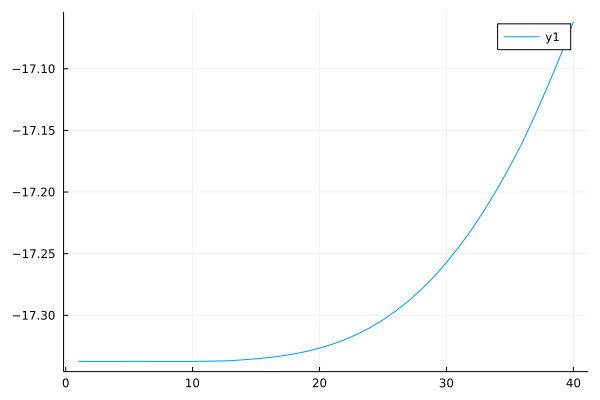

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423
┌ Warning: Module Cairo_jll with build ID 349201218297556 is missing from the cache.
│ This may mean Cairo_jll [83423d85-b0ee-5818-9007-b63ccbeb887a] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9].
└ @ Base loading.jl:1124
┌ Info: Precompiling Qt5Base_jll [ea2cea3b-5b76-57ae-a6ef-0a8af62496e1]
└ @ Base loading.jl:1423
┌ Warning: Module Fontconfig_jll with build ID 349203755823667 is missing from the cache.
│ This may mean Fontconfig_jll [a3f928ae-7b40-5064-980b-68af3947d34b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Info: Skipping precompilation since __precompile__(false). Importing Qt5Base_jll [ea2cea3b-5b76-57ae-a6ef-0a8af62496e1].
└ @ Base loading.jl:1124


In [155]:
plot(energies_ground, energies_t1 energies_t2 energies_t3 energies_t4 energies_t5 energies_t6

In [156]:
display(energies_ground)

40-element Vector{Any}:
 -17.33737605400575
 -17.33740487020998
 -17.337418456133072
 -17.337415584601096
 -17.337376325879166
 -17.33737605400575
 -17.337403836105224
 -17.337418456133022
 -17.337415584600905
 -17.33739258612745
 -17.337284472187918
 -17.33708924451954
 -17.33676751150621
   ⋮
 -17.26892995203632
 -17.257175653424063
 -17.244302944686513
 -17.23017520616588
 -17.214521086883128
 -17.19757412703656
 -17.179271370593515
 -17.159453914061086
 -17.13726418895807
 -17.113836626079966
 -17.08894685798302
 -17.06206120433742

In [164]:
println(energies_t6)

Any[-16.595597906424494, -16.59284842992846, -16.589617048201646, -16.585536109240998, -16.581544577272624, -16.595597906424494, -16.592840376183595, -16.58961785089535, -16.585536032757616, -16.58199812031938, -16.57729080427074, -16.573909892518856, -16.574009106963672, -16.56789571465427, -16.567148179723667, -16.565765525139962, -16.561946208576813, -16.558489030529017, -16.556577119468322, -16.55436421471482, -16.550257517118474, -16.546039413231377, -16.542713452895377, -16.538600262396695, -16.534154349143527, -16.527995403106853, -16.520849459287444, -16.51812419614894, -16.516312600090952, -16.51047302758495, -16.504513723106083, -16.50052367519742, -16.491843611645972, -16.482773689756037, -16.474326094455325, -16.464091741262838, -16.44815261028279, -16.433397122810568, -16.41526951490997, -16.39422511187473]


In [10]:
molecule = "
He 0.00000000 0.00000000 0.00000000
He 2.12132035 0.00000000 0.00000000
He 0.00000000 2.12132035 0.00000000
He 2.12132034 2.12132034 0.00000000
He 1.06066017 1.06066017 1.50000000
He 1.06066017 1.06066017 -1.50000000
"
molecule = "
He 0.00000000 0.00000000 0.00000000
He 1.41421356 0.00000000 0.00000000
He 0.00000000 1.41421356 0.00000000
He 1.41421356 1.41421356 0.00000000
He 0.70710678 0.70710678 1.00000000
He 0.70710678 0.70710678 -1.00000000
"
atoms = []
for (li,line) in enumerate(split(rstrip(lstrip(molecule)), "\n"))
    l = split(line)
    push!(atoms, Atom(li, l[1], parse.(Float64,l[2:4])))
end

basis = "aug-cc-pvdz"

# Create FermiCG.Molecule type
mol     = Molecule(0, 1, atoms,basis);

pyscf = pyimport("pyscf")

n_steps = 60
step_size = .05

pymol_init = pyscf.gto.Mole(atom=molecule,
                            symmetry = false, spin =0,charge=0,
                            basis = basis)
pymol_init.build()

io = open("traj.xyz", "w");
energies_ground = []
energies_t1 = []
energies_t2 = []
energies_t3 = []
energies_t4 = []
energies_t5 = []
energies_t6 = []

energies_s1 = []
energies_s2 = []
energies_s3 = []
energies_s4 = []
energies_s5 = []
energies_s6 = []

energies_t7 = []
energies_t8 = []
energies_t9 = []
energies_t10 = []
energies_t11 = []
energies_t12 = []
pt2_energies = []

lo = pyimport("pyscf.lo.orth")
tools = pyimport("pyscf.tools")
fcidump = pyimport("pyscf.tools.fcidump");
cc = pyimport("pyscf.cc")

PyObject <module 'pyscf.cc' from '/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/__init__.py'>

In [126]:
pymol = deepcopy(pymol_init)
ci = pyimport("pyscf.ci")
tdscf = pyimport("pyscf.tdscf")
for R in 1:n_steps
    println("\n*********** Iteration: ", R, " *************")
    scale = 1+R*step_size
    
    #move to smaller geometry
    xyz = @sprintf("%5i\n\n", length(mol.atoms))
    tmp = []
    #for a in mol.atoms
    #    push!(tmp, ["He", (a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)])
    #    xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)
    #end
    
    #move to larger geometry
    for a in mol.atoms
        push!(tmp, ["He", (a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)])
        xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)
    end
    
    pymol.atom = tmp
    pymol.build()
    println(xyz)
    write(io, xyz);
    
    mf = pyscf.scf.RHF(pymol).run()
    e_hf = mf.e_tot

    #write fci dump file from the modified mo coefficients
    #tools.fcidump.from_mo(pymol, "fcidump.he06_oct", mf.mo_coeff)
    
    #Can just read in pyscf dump file for integrals (once you have already run an scf calculation)
    #ctx = fcidump.read("fcidump.he06_oct");
    #h = ctx["H1"];
    #g = ctx["H2"];
    #ecore = ctx["ECORE"];
    #g = pyscf.ao2mo.restore("1", g, size(h,2))
    #myci = mf.CISD()
    #myci.nroots = 6
    mytd = tdscf.TDA(mf)
    mytd = mytd.run(nstates=18)

    #mycc = cc.RCCSD(mf)
    #mycc.verbose = 7
    #mycc.ccsd()
    roots = mytd.e .+ e_hf
    push!(energies_ground, e_hf)
    push!(energies_t1, roots[1])
    push!(energies_t2, roots[2])
    push!(energies_t3, roots[3])
    push!(energies_t4, roots[4])
    push!(energies_t5, roots[5])
    push!(energies_t6, roots[6])
    
    push!(energies_s1, roots[7])
    push!(energies_s2, roots[8])
    push!(energies_s3, roots[9])
    push!(energies_s4, roots[10])
    push!(energies_s5, roots[11])
    push!(energies_s6, roots[12])

    push!(energies_t7, roots[13])
    push!(energies_t8, roots[14])
    push!(energies_t9, roots[15])
    push!(energies_t10, roots[16])
    push!(energies_t11, roots[17])
    push!(energies_t12, roots[18])
end

    #e = mycc.e_corr + mf.kernel()[1]
    # S->S excitation
    #eS_energies, v = mycc.eomee_ccsd_singlet(nroots=6)
    
    #singlets = eS_energies .+ e
    
    # S->T excitation
    #eT_energies, v2 = mycc2.eomee_ccsd_triplet(nroots=6) 
    #triplets = eT_energies .+ e
    #display(singlets)
    #push!(energies_ground, e)
    #push!(energies_s1, singlets[1])
    #push!(energies_s2, singlets[2])
    #push!(energies_s3, singlets[3])
    #push!(energies_s4, singlets[4])
    #push!(energies_s5, singlets[5])
    #push!(energies_s6, singlets[6])




*********** Iteration: 1 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.4849242380000001       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.4849242380000001       0.0000000000000000 
    He       1.4849242380000001       1.4849242380000001       0.0000000000000000 
    He       0.7424621190000000       0.7424621190000000       1.0500000000000000 
    He       0.7424621190000000       0.7424621190000000      -1.0500000000000000 

converged SCF energy = -16.9362721085342
Excited State energies (eV)
[19.12395094 19.12395095 20.0467465  20.0467465  20.04674651 20.6734807
 20.67348071 20.67348071 22.12761156 22.28863746 22.28863746 22.61470798
 23.74321938 23.74321938 23.74321939 24.51047235 24.51047235 24.51047235]

*********** Iteration: 2 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.5556349160000003     

converged SCF energy = -17.128673502148
Excited State energies (eV)
[22.81034309 22.81034309 22.91165437 22.91165437 22.91165437 23.28576141
 24.48346497 24.48346498 24.48346498 24.77849826 24.77849826 24.77849826
 25.16254958 25.16254958 25.16254958 25.5219152  25.5219152  25.5219152 ]

*********** Iteration: 14 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.4041630520000004       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.4041630520000004       0.0000000000000000 
    He       2.4041630520000004       2.4041630520000004       0.0000000000000000 
    He       1.2020815260000002       1.2020815260000002       1.7000000000000002 
    He       1.2020815260000002       1.2020815260000002      -1.7000000000000002 

converged SCF energy = -17.1301892913454
Excited State energies (eV)
[22.90572941 22.90572941 22.98707437 22.98707438 22.98707438 23.28505495
 24.57735355 24.5773535

*********** Iteration: 26 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       3.2526911880000000       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       3.2526911880000000       0.0000000000000000 
    He       3.2526911880000000       3.2526911880000000       0.0000000000000000 
    He       1.6263455940000000       1.6263455940000000       2.2999999999999998 
    He       1.6263455940000000       1.6263455940000000      -2.2999999999999998 

converged SCF energy = -17.1342330475705
Excited State energies (eV)
[22.5502165  22.5502165  22.5716177  22.5716177  22.5716177  22.61541519
 24.84209448 24.84209448 24.89050362 24.89050362 24.89050362 25.0783885
 25.22171315 25.22171315 25.22171315 25.22425266 25.22425266 25.22425266]

*********** Iteration: 27 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       3.3234018660000002    

converged SCF energy = -17.1342326044851
Excited State energies (eV)
[22.20789421 22.20789421 22.21037377 22.21037377 22.21037377 22.21583759
 25.1932981  25.1932981  25.20157649 25.20157649 25.20157649 25.23324226
 26.03047887 26.03047887 26.03047887 26.03675963 26.03675963 26.03675963]

*********** Iteration: 39 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       4.1719300020000007       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       4.1719300020000007       0.0000000000000000 
    He       4.1719300020000007       4.1719300020000007       0.0000000000000000 
    He       2.0859650010000004       2.0859650010000004       2.9500000000000002 
    He       2.0859650010000004       2.0859650010000004      -2.9500000000000002 

converged SCF energy = -17.1342320320024
Excited State energies (eV)
[22.21021143 22.21021143 22.21223595 22.21223595 22.21223595 22.21668604
 25.23314977 25.233149

*********** Iteration: 51 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       5.0204581380000004       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       5.0204581380000004       0.0000000000000000 
    He       5.0204581380000004       5.0204581380000004       0.0000000000000000 
    He       2.5102290690000002       2.5102290690000002       3.5500000000000003 
    He       2.5102290690000002       2.5102290690000002      -3.5500000000000003 

converged SCF energy = -17.1342285250547
Excited State energies (eV)
[22.3372149  22.3372149  22.33737972 22.33737972 22.33737972 22.33771915
 25.92030014 25.92030014 25.92158788 25.92158788 25.92158788 25.92604005
 26.80062289 26.80062289 26.80062289 26.80161885 26.80161885 26.80161885]

*********** Iteration: 52 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       5.0911688160000006   

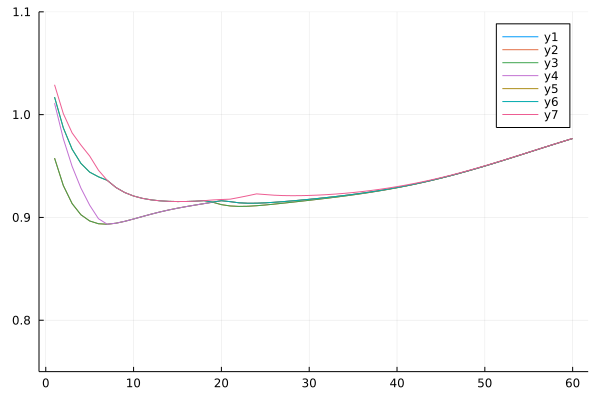

In [138]:
#Singlets
plot([energies_ground.-energies_ground[end], energies_s1.-energies_ground[end], energies_s2.-energies_ground[end],energies_s3.-energies_ground[end],energies_s4.-energies_ground[end],energies_s5.-energies_ground[end],energies_s6.-energies_ground[end]])
ylims!((0.75,1.1))

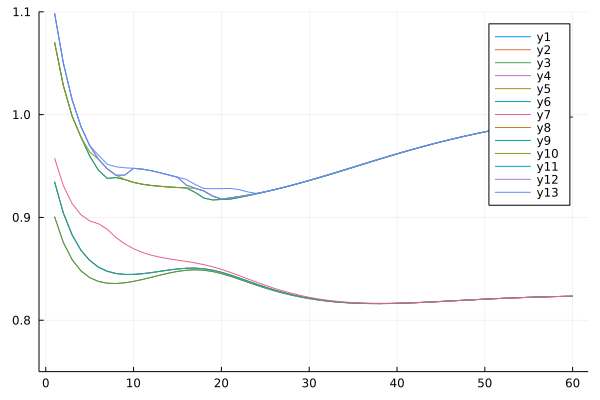

In [141]:
#Triplets
#plot([energies_ground.-energies_ground[end], energies_t1.-energies_ground[end], energies_t2.-energies_ground[end], energies_t3.-energies_ground[end], energies_t4.-energies_ground[end], energies_t5.-energies_ground[end],energies_t6.-energies_ground[end],energies_t7.-energies_ground[end], energies_t8.-energies_ground[end], energies_t9.-energies_ground[end], energies_t10.-energies_ground[end], energies_t11.-energies_ground[end],energies_t12.-energies_ground[end], energies_s1.-energies_ground[end], energies_s2.-energies_ground[end],energies_s3.-energies_ground[end],energies_s4.-energies_ground[end],energies_s5.-energies_ground[end],energies_s6.-energies_ground[end]])
plot([energies_ground.-energies_ground[end], energies_t1.-energies_ground[end], energies_t2.-energies_ground[end], energies_t3.-energies_ground[end], energies_t4.-energies_ground[end], energies_t5.-energies_ground[end],energies_t6.-energies_ground[end],energies_t7.-energies_ground[end], energies_t8.-energies_ground[end], energies_t9.-energies_ground[end], energies_t10.-energies_ground[end], energies_t11.-energies_ground[end],energies_t12.-energies_ground[end]])
ylims!(0.75,1.1)

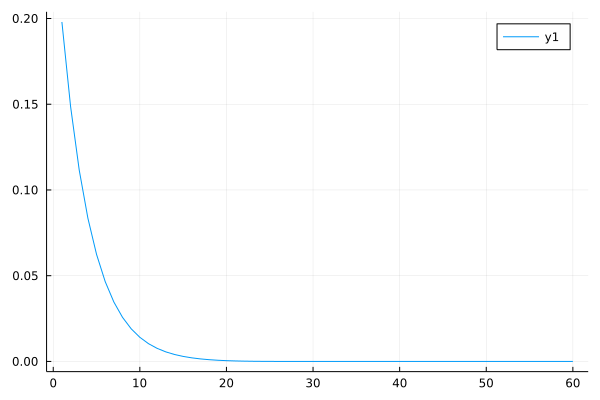

In [139]:
plot([energies_ground.-energies_ground[end]])

In [111]:
energies_ground[end]

-17.13422825166819

In [17]:
s1 = []
s2 = []
s3 = []
s4 = []
s5 = []
s6 = []
s7 = []
s8 = []
s9 = []
s10 = []
s11 = []
s12 = []

ground = []

pymol = deepcopy(pymol_init)
ci = pyimport("pyscf.ci")
tdscf = pyimport("pyscf.tdscf")
for R in 1:n_steps
    println("\n*********** Iteration: ", R, " *************")
    scale = 1+R*step_size
    
    #move to smaller geometry
    xyz = @sprintf("%5i\n\n", length(mol.atoms))
    tmp = []
    #for a in mol.atoms
    #    push!(tmp, ["He", (a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)])
    #    xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)
    #end
    
    #move to larger geometry
    for a in mol.atoms
        push!(tmp, ["He", (a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)])
        xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)
    end
    
    pymol.atom = tmp
    pymol.build()
    println(xyz)
    write(io, xyz);
    
    mf = pyscf.scf.RHF(pymol).run()
    e_hf = mf.e_tot

    mycc = cc.RCCSD(mf)
    mycc.verbose = 7
    mycc.ccsd()
    e = mycc.e_corr + e_hf
    
    #eip,cip = mycc.ipccsd(nroots=6)
    #eea,cea = mycc.eaccsd(nroots=1)
    #eee,cee = mycc.eeccsd(nroots=6)
    
   
    
    
    # S->S excitation
    eS_energies, v = mycc.eomee_ccsd_singlet(nroots=6)
    singlets = eS_energies .+ e
    #display(singlets)
    push!(ground, e)
    push!(s1, singlets[1])
    push!(s2, singlets[2])
    push!(s3, singlets[3])
    push!(s4, singlets[4])
    push!(s5, singlets[5])
    push!(s6, singlets[6])
    #push!(s7, singlets[7])
    #push!(s8, singlets[8])
    #push!(s9, singlets[9])
    #push!(s10, singlets[10])
    #push!(s11, singlets[11])
    #push!(s12, singlets[12])
    
    # S->T excitation
    #eT_energies, v2 = mycc.eomee_ccsd_triplet(nroots=6) 
    #triplets = eT_energies .+ e
    #push!(t1, triplets[1])
    #push!(t2, triplets[2])
    #push!(t3, triplets[3])
    #push!(t4, triplets[4])
    #push!(t5, triplets[5])
    #push!(t6, triplets[6])
end


*********** Iteration: 1 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.4849242380000001       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.4849242380000001       0.0000000000000000 
    He       1.4849242380000001       1.4849242380000001       0.0000000000000000 
    He       0.7424621190000000       0.7424621190000000       1.0500000000000000 
    He       0.7424621190000000       0.7424621190000000      -1.0500000000000000 

    CPU time for vvvv [24:36]      0.01 sec, wall time      0.00 sec
converged SCF energy = -16.9362721085342

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.51 sec, wall tim

*********** Iteration: 2 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.5556349160000003       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.5556349160000003       0.0000000000000000 
    He       1.5556349160000003       1.5556349160000003       0.0000000000000000 
    He       0.7778174580000001       0.7778174580000001       1.1000000000000001 
    He       0.7778174580000001       0.7778174580000001      -1.1000000000000001 

converged SCF energy = -16.9854342062006

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.51 sec, wall time      0.12 sec
Init t2, MP2 energy = -17.1564230366815  E_corr(MP2) -

*********** Iteration: 3 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.6263455940000000       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.6263455940000000       0.0000000000000000 
    He       1.6263455940000000       1.6263455940000000       0.0000000000000000 
    He       0.8131727970000000       0.8131727970000000       1.1499999999999999 
    He       0.8131727970000000       0.8131727970000000      -1.1499999999999999 

converged SCF energy = -17.0226184973274

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.54 sec, wall time      0.11 sec
Init t2, MP2 energy = -17.1921760006036  E_corr(MP2) -

*********** Iteration: 4 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.6970562720000000       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.6970562720000000       0.0000000000000000 
    He       1.6970562720000000       1.6970562720000000       0.0000000000000000 
    He       0.8485281360000000       0.8485281360000000       1.2000000000000000 
    He       0.8485281360000000       0.8485281360000000      -1.2000000000000000 

converged SCF energy = -17.0506735460583

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.51 sec, wall time      0.10 sec
Init t2, MP2 energy = -17.2190730592295  E_corr(MP2) -

*********** Iteration: 5 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.7677669500000002       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.7677669500000002       0.0000000000000000 
    He       1.7677669500000002       1.7677669500000002       0.0000000000000000 
    He       0.8838834750000001       0.8838834750000001       1.2500000000000000 
    He       0.8838834750000001       0.8838834750000001      -1.2500000000000000 

converged SCF energy = -17.0717996844229

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.43 sec, wall time      0.12 sec
Init t2, MP2 energy = -17.2392485773453  E_corr(MP2) -

*********** Iteration: 6 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.8384776280000001       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.8384776280000001       0.0000000000000000 
    He       1.8384776280000001       1.8384776280000001       0.0000000000000000 
    He       0.9192388140000001       0.9192388140000001       1.3000000000000000 
    He       0.9192388140000001       0.9192388140000001      -1.3000000000000000 

converged SCF energy = -17.0876829663651

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.54 sec, wall time      0.10 sec
Init t2, MP2 energy = -17.2543401500273  E_corr(MP2) -

*********** Iteration: 7 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.9091883060000003       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.9091883060000003       0.0000000000000000 
    He       1.9091883060000003       1.9091883060000003       0.0000000000000000 
    He       0.9545941530000002       0.9545941530000002       1.3500000000000001 
    He       0.9545941530000002       0.9545941530000002      -1.3500000000000001 

converged SCF energy = -17.0996050275781

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.54 sec, wall time      0.10 sec
Init t2, MP2 energy = -17.2655953461557  E_corr(MP2) -

*********** Iteration: 8 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.9798989840000001       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.9798989840000001       0.0000000000000000 
    He       1.9798989840000001       1.9798989840000001       0.0000000000000000 
    He       0.9899494920000000       0.9899494920000000       1.3999999999999999 
    He       0.9899494920000000       0.9899494920000000      -1.3999999999999999 

converged SCF energy = -17.1085358376283

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.53 sec, wall time      0.10 sec
Init t2, MP2 energy = -17.2739603706125  E_corr(MP2) -

*********** Iteration: 9 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.0506096620000003       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.0506096620000003       0.0000000000000000 
    He       2.0506096620000003       2.0506096620000003       0.0000000000000000 
    He       1.0253048310000001       1.0253048310000001       1.4500000000000000 
    He       1.0253048310000001       1.0253048310000001      -1.4500000000000000 

converged SCF energy = -17.1152097262727

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.57 sec, wall time      0.10 sec
Init t2, MP2 energy = -17.2801523670216  E_corr(MP2) -

*********** Iteration: 10 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.1213203400000000       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.1213203400000000       0.0000000000000000 
    He       2.1213203400000000       2.1213203400000000       0.0000000000000000 
    He       1.0606601700000000       1.0606601700000000       1.5000000000000000 
    He       1.0606601700000000       1.0606601700000000      -1.5000000000000000 

converged SCF energy = -17.1201843910572

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.56 sec, wall time      0.10 sec
Init t2, MP2 energy = -17.2847157401741  E_corr(MP2) 

*********** Iteration: 11 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.1920310180000002       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.1920310180000002       0.0000000000000000 
    He       2.1920310180000002       2.1920310180000002       0.0000000000000000 
    He       1.0960155090000001       1.0960155090000001       1.5500000000000000 
    He       1.0960155090000001       1.0960155090000001      -1.5500000000000000 

converged SCF energy = -17.1238844470855

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.29 sec, wall time      0.19 sec
Init t2, MP2 energy = -17.288064126629  E_corr(MP2) -

*********** Iteration: 12 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.2627416960000004       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.2627416960000004       0.0000000000000000 
    He       2.2627416960000004       2.2627416960000004       0.0000000000000000 
    He       1.1313708480000002       1.1313708480000002       1.6000000000000001 
    He       1.1313708480000002       1.1313708480000002      -1.6000000000000001 

converged SCF energy = -17.1266327924302

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.55 sec, wall time      0.11 sec
Init t2, MP2 energy = -17.2905110138328  E_corr(MP2) 

*********** Iteration: 13 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.3334523740000002       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.3334523740000002       0.0000000000000000 
    He       2.3334523740000002       2.3334523740000002       0.0000000000000000 
    He       1.1667261870000001       1.1667261870000001       1.6499999999999999 
    He       1.1667261870000001       1.1667261870000001      -1.6499999999999999 

converged SCF energy = -17.128673502148

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.50 sec, wall time      0.11 sec
Init t2, MP2 energy = -17.2922923650846  E_corr(MP2) -

*********** Iteration: 14 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.4041630520000004       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.4041630520000004       0.0000000000000000 
    He       2.4041630520000004       2.4041630520000004       0.0000000000000000 
    He       1.2020815260000002       1.2020815260000002       1.7000000000000002 
    He       1.2020815260000002       1.2020815260000002      -1.7000000000000002 



Excessive output truncated after 552254 bytes.

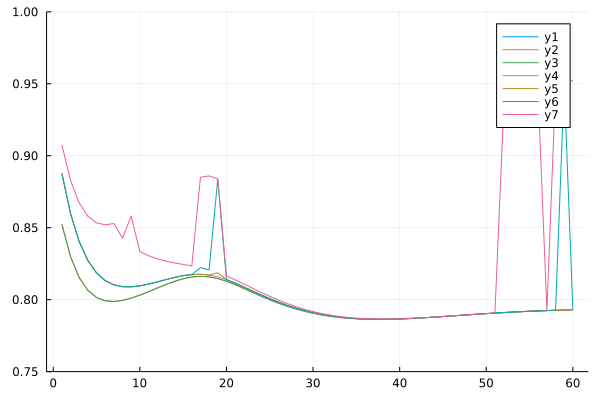

In [5]:
plot([ground.-ground[end], s1.-ground[end], s2.-ground[end],s3.-ground[end],s4.-ground[end],s5.-ground[end],s6.-ground[end], s7.-ground[end], s8.-ground[end],s9.-ground[end],s10.-ground[end],s11.-ground[end],s12.-ground[end]])
ylims!((0.75,1))

In [16]:
plot([ground.-ground[end]])

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [0]

In [182]:
molecule = "
    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.8384776280000001       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.8384776280000001       0.0000000000000000 
    He       1.8384776280000001       1.8384776280000001       0.0000000000000000 
    He       0.9192388140000001       0.9192388140000001       1.3000000000000000 
    He       0.9192388140000001       0.9192388140000001      -1.3000000000000000
" 

atoms = []
for (li,line) in enumerate(split(rstrip(lstrip(molecule)), "\n"))
    l = split(line)
    push!(atoms, Atom(li, l[1], parse.(Float64,l[2:4])))
end

basis = "aug-cc-pvdz"

# Create FermiCG.Molecule type
mol     = Molecule(0, 1, atoms,basis);

pyscf = pyimport("pyscf")

n_steps = 40
step_size = .05

pymol_init = pyscf.gto.Mole(atom=molecule,
                            symmetry = false, spin =0,charge=0,
                            basis = basis)
pymol_init.build()

io = open("traj.xyz", "w");
g = []
t1 = []
t2 = []
t3 = []
t4 = []
t5 = []
t6 = []
t7 = []
t8 = []
t9 = []
t10 = []
t11 = []
t12 = []

pymol = deepcopy(pymol_init)
ci = pyimport("pyscf.ci")
tdscf = pyimport("pyscf.tdscf")
for R in 1:n_steps
    println("\n*********** Iteration: ", R, " *************")
    scale = 1+R*step_size
    
    #move to smaller geometry
    xyz = @sprintf("%5i\n\n", length(mol.atoms))
    tmp = []
    #for a in mol.atoms
    #    push!(tmp, ["He", (a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)])
    #    xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]/scale, a.xyz[2]/scale, a.xyz[3]/scale)
    #end
    
    #move to larger geometry
    for a in mol.atoms
        push!(tmp, ["He", (a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)])
        xyz = xyz * @sprintf("%6s %24.16f %24.16f %24.16f \n", a.symbol, a.xyz[1]*scale, a.xyz[2]*scale, a.xyz[3]*scale)
    end
    
    pymol.atom = tmp
    pymol.build()
    println(xyz)
    write(io, xyz);
    
    mf = pyscf.scf.RHF(pymol).run()
    e_hf = mf.e_tot

    mycc = cc.RCCSD(mf)
    mycc.verbose = 7
    mycc.ccsd()
    e = mycc.e_corr + e_hf
    
    # S->T excitation
    eT_energies, v2 = mycc.eomee_ccsd_triplet(nroots=6) 
    triplets = eT_energies .+ e
    
    push!(g, e)
    push!(t1, triplets[1])
    push!(t2, triplets[2])
    push!(t3, triplets[3])
    push!(t4, triplets[4])
    push!(t5, triplets[5])
    push!(t6, triplets[6])
    #push!(t7, triplets[7])
    #push!(t8, triplets[8])
    #push!(t9, triplets[9])
    #push!(t10, triplets[10])
    #push!(t11, triplets[11])
    #push!(t12, triplets[12])
end


*********** Iteration: 1 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       1.9304015094000002       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       1.9304015094000002       0.0000000000000000 
    He       1.9304015094000002       1.9304015094000002       0.0000000000000000 
    He       0.9652007547000001       0.9652007547000001       1.3650000000000002 
    He       0.9652007547000001       0.9652007547000001      -1.3650000000000002 

    CPU time for vvvv [36:48]      0.03 sec, wall time      0.00 sec
converged SCF energy = -17.1025609752904

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.54 sec, wall tim

*********** Iteration: 2 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.0223253908000003       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.0223253908000003       0.0000000000000000 
    He       2.0223253908000003       2.0223253908000003       0.0000000000000000 
    He       1.0111626954000001       1.0111626954000001       1.4300000000000002 
    He       1.0111626954000001       1.0111626954000001      -1.4300000000000002 

converged SCF energy = -17.112771924777

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.54 sec, wall time      0.13 sec
Init t2, MP2 energy = -17.277898170079  E_corr(MP2) -0.

*********** Iteration: 3 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.1142492721999999       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.1142492721999999       0.0000000000000000 
    He       2.1142492721999999       2.1142492721999999       0.0000000000000000 
    He       1.0571246361000000       1.0571246361000000       1.4949999999999999 
    He       1.0571246361000000       1.0571246361000000      -1.4949999999999999 

converged SCF energy = -17.119750403657

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.58 sec, wall time      0.10 sec
Init t2, MP2 energy = -17.2843200315435  E_corr(MP2) -0

*********** Iteration: 4 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.2061731536000000       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.2061731536000000       0.0000000000000000 
    He       2.2061731536000000       2.2061731536000000       0.0000000000000000 
    He       1.1030865768000000       1.1030865768000000       1.5600000000000001 
    He       1.1030865768000000       1.1030865768000000      -1.5600000000000001 

converged SCF energy = -17.1245014309152

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.32 sec, wall time      0.11 sec
Init t2, MP2 energy = -17.2886170794435  E_corr(MP2) -

*********** Iteration: 5 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.2980970350000001       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.2980970350000001       0.0000000000000000 
    He       2.2980970350000001       2.2980970350000001       0.0000000000000000 
    He       1.1490485175000000       1.1490485175000000       1.6250000000000000 
    He       1.1490485175000000       1.1490485175000000      -1.6250000000000000 

converged SCF energy = -17.1277289214629

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.56 sec, wall time      0.10 sec
Init t2, MP2 energy = -17.2914726599408  E_corr(MP2) -

*********** Iteration: 6 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.3900209164000001       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.3900209164000001       0.0000000000000000 
    He       2.3900209164000001       2.3900209164000001       0.0000000000000000 
    He       1.1950104582000001       1.1950104582000001       1.6900000000000002 
    He       1.1950104582000001       1.1950104582000001      -1.6900000000000002 

converged SCF energy = -17.1299210480777

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.57 sec, wall time      0.10 sec
Init t2, MP2 energy = -17.2933580662471  E_corr(MP2) -

*********** Iteration: 7 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.4819447978000002       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.4819447978000002       0.0000000000000000 
    He       2.4819447978000002       2.4819447978000002       0.0000000000000000 
    He       1.2409723989000001       1.2409723989000001       1.7550000000000001 
    He       1.2409723989000001       1.2409723989000001      -1.7550000000000001 

converged SCF energy = -17.1314107590713

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.64 sec, wall time      0.15 sec
Init t2, MP2 energy = -17.2945927843076  E_corr(MP2) -

*********** Iteration: 8 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.5738686791999998       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.5738686791999998       0.0000000000000000 
    He       2.5738686791999998       2.5738686791999998       0.0000000000000000 
    He       1.2869343395999999       1.2869343395999999       1.8199999999999998 
    He       1.2869343395999999       1.2869343395999999      -1.8199999999999998 

converged SCF energy = -17.1324216001157

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.56 sec, wall time      0.11 sec
Init t2, MP2 energy = -17.2953900174471  E_corr(MP2) -

*********** Iteration: 9 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.6657925605999999       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.6657925605999999       0.0000000000000000 
    He       2.6657925605999999       2.6657925605999999       0.0000000000000000 
    He       1.3328962803000000       1.3328962803000000       1.8850000000000000 
    He       1.3328962803000000       1.3328962803000000      -1.8850000000000000 

converged SCF energy = -17.1331027845425

******** <class 'pyscf.cc.ccsd.CCSD'> ********
CC2 = 0
CCSD nocc = 6, nmo = 54
max_cycle = 50
direct = 0
conv_tol = 1e-07
conv_tol_normt = 1e-05
diis_space = 6
diis_start_cycle = 0
diis_start_energy_diff = 1e+09
max_memory 4000 MB (current use 0 MB)
total FLOPs 661146624.0
    CPU time for CCSD integral transformation      0.58 sec, wall time      0.10 sec
Init t2, MP2 energy = -17.2958912418436  E_corr(MP2) -

Excessive output truncated after 560380 bytes.

 *************
    6

    He       0.0000000000000000       0.0000000000000000       0.0000000000000000 
    He       2.7577164420000004       0.0000000000000000       0.0000000000000000 
    He       0.0000000000000000       2.7577164420000004       0.0000000000000000 
    He       2.7577164420000004       2.7577164420000004       0.0000000000000000 
    He       1.3788582210000002       1.3788582210000002       1.9500000000000002 
    He       1.3788582210000002       1.3788582210000002      -1.9500000000000002 



LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/nicole/.julia/packages/PyCall/L0fLP/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'BlockingIOError'>
BlockingIOError(35, 'write could not complete without blocking', 0)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/ccsd.py", line 1114, in eomee_ccsd_triplet
    return eom_rccsd.EOMEETriplet(self).kernel(nroots, koopmans, guess, eris)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/eom_rccsd.py", line 1060, in eomee_ccsd_triplet
    return eomee_ccsd_singlet(eom, nroots, koopmans, guess, eris, imds, diag)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/eom_rccsd.py", line 1053, in eomee_ccsd_singlet
    = kernel(eom, nroots, koopmans, guess, eris=eris, imds=imds, diag=diag)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/eom_rccsd.py", line 79, in kernel
    max_space=eom.max_space, nroots=nroots, verbose=log)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/lib/linalg_helper.py", line 822, in davidson_nosym1
    axt = aop(xt)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/eom_rccsd.py", line 1681, in <lambda>
    matvec = lambda xs: [self.matvec(x, imds) for x in xs]
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/eom_rccsd.py", line 1681, in <listcomp>
    matvec = lambda xs: [self.matvec(x, imds) for x in xs]
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/eom_rccsd.py", line 1253, in eeccsd_matvec_triplet
    Hr2ab = eom._cc._add_vvvv(None, tau2ab, eris, with_ovvv=False, t2sym='-jiba')
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/ccsd.py", line 367, in _add_vvvv
    Ht2tril = _add_vvvv_tril(mycc, t1, t2, eris, with_ovvv=with_ovvv)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/ccsd.py", line 424, in _add_vvvv_tril
    Ht2tril = eris._contract_vvvv_t2(mycc, tau, mycc.direct, out, log)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/ccsd.py", line 1336, in _contract_vvvv_t2
    return _contract_vvvv_t2(mycc, self.mol, vvvv, t2, out, verbose)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/ccsd.py", line 471, in _contract_vvvv_t2
    return _contract_s4vvvv_t2(mycc, mol, vvvv, t2, out, verbose)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/cc/ccsd.py", line 595, in _contract_s4vvvv_t2
    time0 = log.timer_debug1('vvvv [%d:%d]'%(i0,i1), *time0)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/lib/logger.py", line 184, in timer_debug1
    return timer(rec, msg, cpu0, wall0)
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/lib/logger.py", line 174, in timer
    % (msg, rec._t0-cpu0, rec._w0-wall0))
  File "/Users/nicole/opt/anaconda3/envs/tpsci/lib/python3.7/site-packages/pyscf/lib/logger.py", line 117, in flush
    rec.stdout.flush()


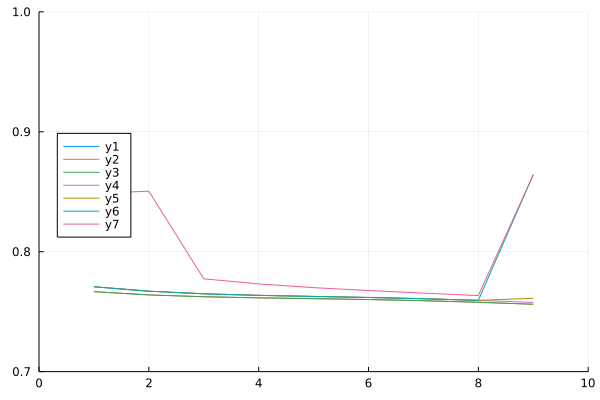

In [185]:
plot([ground.-ground[end], t1.-ground[end], t2.-ground[end],t3.-ground[end],t4.-ground[end],t5.-ground[end],t6.-ground[end]], legend=:left)
ylims!((0.7,1))
xlims!((0,10))

In [183]:
t1

9-element Vector{Any}:
 -16.570647988778973
 -16.573346968493784
 -16.57488468700369
 -16.5757958660356
 -16.57647287245219
 -16.577200903018046
 -16.578170110237217
 -16.579477299937814
 -16.58113009500698